In [1]:
import dgl
from dgl.data import CiteseerGraphDataset
from GraphSummarizers.Coarsener.HeteroCoarsener import HeteroCoarsener
import torch


/home/robin/uu/thesis/convolution-matching/.venvconv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import dgl
from dgl.data import CiteseerGraphDataset
import torch
from sklearn.decomposition import PCA

# Load the homogeneous Citeseer citation graph
dataset = CiteseerGraphDataset()
g = dataset[0]

# Original node features
data = g.ndata['feat']  # shape: (num_nodes, orig_feat_dim)

# Apply PCA to reduce feature dimension
# Choose the number of principal components
def reduce_features(feat_tensor, n_components=50):
    """
    Reduce feature dimension using PCA.

    Parameters
    ----------
    feat_tensor : torch.Tensor
        Input node features of shape (N, D).
    n_components : int
        Target number of dimensions.

    Returns
    -------
    torch.Tensor
        Transformed features of shape (N, n_components).
    """
    # Convert to numpy for sklearn PCA
    X = feat_tensor.numpy()
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return torch.from_numpy(X_reduced)

# Reduce to 50 dimensions (you can adjust this)
reduced_feat = reduce_features(data, n_components=50)

# Build heterogeneous graph with 'cites' and 'cited-by' relations
src, dst = g.edges()
data_dict = {
    ('paper', 'cites', 'paper'): (src, dst),
    ('paper', 'cited-by', 'paper'): (dst, src)
}
hetero_g = dgl.heterograph(data_dict)

# Assign reduced features and other data
hetero_g.nodes['paper'].data['feat'] = reduced_feat
hetero_g.nodes['paper'].data['label'] = g.ndata['label']
for key in ['train_mask', 'val_mask', 'test_mask']:
    hetero_g.nodes['paper'].data[key] = g.ndata[key]

# Inspect the resulting heterogeneous graph
print(hetero_g)
print("Feature shape after PCA:", hetero_g.nodes['paper'].data['feat'].shape)
print("Edge types:", hetero_g.etypes)
print("Node types:", hetero_g.ntypes)


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Graph(num_nodes={'paper': 3327},
      num_edges={('paper', 'cited-by', 'paper'): 9228, ('paper', 'cites', 'paper'): 9228},
      metagraph=[('paper', 'paper', 'cited-by'), ('paper', 'paper', 'cites')])
Feature shape after PCA: torch.Size([3327, 50])
Edge types: ['cited-by', 'cites']
Node types: ['paper']


In [3]:

coarsener = HeteroCoarsener(None,hetero_g, 0.5, num_nearest_per_etype=30, num_nearest_neighbors=30,pairs_per_level=50)
coarsener.init_step()

_create_h_spatial_rgcn 2.49273681640625
stop init costs 0.8478543758392334
_get_union 0.30236363410949707
feat 
neighbor
_add_costs 4.66753625869751
_costs_of_merges 48.29802346229553
_init_merge_graph 0.008298635482788086
_find_lowest_cost_edges 0.021141529083251953


In [4]:
original_graph = hetero_g

In [34]:
isNewMerges = True
for i in range(10):
    if not isNewMerges:
        break
    print("--------- step: " , i , "---------" )
    isNewMerges = coarsener.iteration_step()
    

--------- step:  0 ---------
_find_lowest_cost_edges 0.03478598594665527


In [35]:
coarsend_graph = coarsener.get_coarsend_graph()

mapping = coarsener.get_mapping("paper")
labels = coarsener._get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))])


In [36]:
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 

ratio 0.49894800120228433


In [48]:
# 2. Utility: create train/val/test indices and corresponding labels

def get_splits_and_labels(hetero_graph, ntype='paper'):
    """
    Extract train/val/test node indices and their labels for a given node type.

    Returns
    -------
    dict
        {
          'train_idx': LongTensor,
          'val_idx': LongTensor,
          'test_idx': LongTensor,
          'train_labels': LongTensor,
          'val_labels': LongTensor,
          'test_labels': LongTensor
        }
    """
    labels = hetero_graph.nodes[ntype].data['label']
    train_mask = hetero_graph.nodes[ntype].data['train_mask']
    val_mask = hetero_graph.nodes[ntype].data['val_mask']
    test_mask = hetero_graph.nodes[ntype].data['test_mask']

    train_idx = train_mask.nonzero(as_tuple=True)[0]
    val_idx = val_mask.nonzero(as_tuple=True)[0]
    test_idx = test_mask.nonzero(as_tuple=True)[0]

    return {
        'train_idx': train_idx,
        'val_idx': val_idx,
        'test_idx': test_idx,
        'train_labels': labels[train_idx],
        'val_labels': labels[val_idx],
        'test_labels': labels[test_idx]
    }

# Example usage:

In [49]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.data import CiteseerGraphDataset
from sklearn.decomposition import PCA
from dgl.nn import HeteroGraphConv, GraphConv

NodeSpace(data={'feat': tensor([[-0.0045, -0.0226, -0.0177,  ...,  0.0116,  0.0231,  0.0057],
        [-0.0061,  0.0222,  0.0114,  ..., -0.0016, -0.0033, -0.0131],
        [ 0.0226,  0.0144, -0.0096,  ..., -0.0193,  0.0210,  0.0048],
        ...,
        [-0.0296,  0.0030, -0.0058,  ..., -0.0090, -0.0163,  0.0020],
        [-0.0002, -0.0077,  0.0156,  ..., -0.0178,  0.0060, -0.0108],
        [ 0.0074,  0.0115, -0.0088,  ...,  0.0046,  0.0244, -0.0037]]), 'label': tensor([3, 1, 5,  ..., 3, 1, 5]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])})

In [50]:
class HeteroGCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, rel_names):
        super().__init__()
        # conv1: in_dim -> hidden_dim for each relation
        self.conv1 = HeteroGraphConv({
            rel: GraphConv(in_dim, hidden_dim)
            for rel in rel_names
        }, aggregate='sum')
        # conv2: hidden_dim -> out_dim for each relation
        self.conv2 = HeteroGraphConv({
            rel: GraphConv(hidden_dim, out_dim)
            for rel in rel_names
        }, aggregate='sum')

    def forward(self, graph, x_dict):
        # x_dict: {'paper': feature_tensor}
        h_dict = self.conv1(graph, x_dict)
        # apply activation
        h_dict = {ntype: F.relu(h) for ntype, h in h_dict.items()}
        h_dict = self.conv2(graph, h_dict)
        return h_dict

Epoch 1:
  Original Graph - Loss: 1.7921, Accuracy: 0.3560
  Coarsened Graph - Loss: 1.7930, Accuracy: 0.2039
  Inverted Coarsened - Accuracy: 0.2639

Epoch 11:
  Original Graph - Loss: 1.6666, Accuracy: 0.5280
  Coarsened Graph - Loss: 1.6762, Accuracy: 0.3738
  Inverted Coarsened - Accuracy: 0.3802

Epoch 21:
  Original Graph - Loss: 1.4573, Accuracy: 0.5860
  Coarsened Graph - Loss: 1.5532, Accuracy: 0.4320
  Inverted Coarsened - Accuracy: 0.4323

Epoch 31:
  Original Graph - Loss: 1.1757, Accuracy: 0.6100
  Coarsened Graph - Loss: 1.3747, Accuracy: 0.4515
  Inverted Coarsened - Accuracy: 0.4618

Epoch 41:
  Original Graph - Loss: 0.8941, Accuracy: 0.6360
  Coarsened Graph - Loss: 1.1611, Accuracy: 0.4854
  Inverted Coarsened - Accuracy: 0.4844

Epoch 51:
  Original Graph - Loss: 0.6711, Accuracy: 0.6440
  Coarsened Graph - Loss: 0.9473, Accuracy: 0.5243
  Inverted Coarsened - Accuracy: 0.5191

Epoch 61:
  Original Graph - Loss: 0.5200, Accuracy: 0.6400
  Coarsened Graph - Loss: 0.7

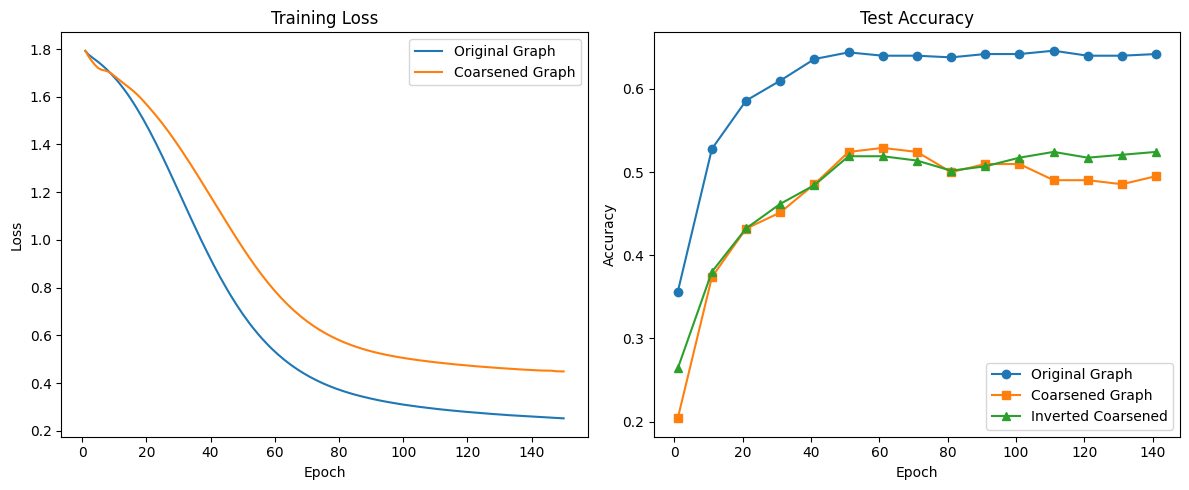

Final Performance Comparison:
Original Graph Accuracy: 0.6420
Coarsened Graph Accuracy: 0.4951
Inverted Coarsened Accuracy: 0.5243


In [73]:
# Import necessary libraries (if not already imported)
import torch
import torch.nn.functional as F
import numpy as np
from Models.GNNs.HGCN import ImprovedHeteroGNN

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_original = HeteroGCN(in_dim=original_graph.nodes["paper"].data["feat"].shape[1], hidden_dim=64,
                  out_dim=dataset.num_classes, rel_names=hetero_g.etypes)


feat_orig = {'paper': original_graph.nodes['paper'].data['feat']}

# Use our splits utility
data_splits_orig = get_splits_and_labels(original_graph)
train_idx_orig = data_splits_orig['train_idx']
val_idx_orig = data_splits_orig['val_idx']
test_idx_orig = data_splits_orig['test_idx']
labels_orig = original_graph.nodes['paper'].data['label']

optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)



model_coarsened = HeteroGCN(in_dim=coarsend_graph.nodes["paper"].data["feat"].shape[1], hidden_dim=64,
                  out_dim=dataset.num_classes, rel_names=hetero_g.etypes)


feat_coar = {'paper': coarsend_graph.nodes['paper'].data['feat']}

# Use our splits utility
data_splits_coar = get_splits_and_labels(coarsend_graph)
train_idx_coar = data_splits_coar['train_idx']
val_idx_coar = data_splits_coar['val_idx']
test_idx_coar = data_splits_coar['test_idx']
labels_coar = coarsend_graph.nodes['paper'].data['label']

optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.01, weight_decay=5e-4)





target_node_type = "paper"



# Function to apply inversion mapping from coarsened to original
def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels, test_mask):
    """
    Maps predictions from coarsened graph back to original graph nodes
    
    Args:
        coarsened_pred: Predictions on coarsened graph
        inversion_map: Mapping from coarsened nodes to original nodes
        original_labels: Ground truth labels of original graph
        
    Returns:
        mapped_accuracy: Accuracy after applying inversion mapping
    """
    correct_count = 0
    total_count = 0
    
    for orig_node, coarsened_node in inversion_map.items():
        if not coarsened_node in test_mask:
            continue
        coarse_pred = coarsened_pred[coarsened_node]
        orig_label = original_labels[orig_node]
        #print(coarse_pred, orig_label)

        correct = (coarse_pred == orig_label)
    
                
        if correct:
            correct_count += 1
     #   else:
      #      print(f"Mismatch: Coarsened Node {coarsened_node} predicted {coarse_pred}, Original Node {orig_node} label {orig_label}")
        total_count += 1
    
    return correct_count / total_count if total_count > 0 else 0

# Training function for original graph
def train_original():
    model_original.train()
    optimizer_original.zero_grad()
    
    #print(original_x_original_data.edge_index_dict)
    logits = model_original(original_graph, feat_orig)['paper']
    loss = F.cross_entropy(logits[train_idx_orig], labels_orig[train_idx_orig])
    loss.backward()
    optimizer_original.step()
    return loss.item()

# Training function for coarsened graph
def train_coarsened():
    model_coarsened.train()
    optimizer_coarsened.zero_grad()
    logits = model_coarsened(coarsend_graph, feat_coar)["paper"]
    loss = F.cross_entropy(logits[train_idx_coar], labels_coar[train_idx_coar])
    
    loss.backward()
    optimizer_coarsened.step()
    return loss.item()

    
# Evaluation function for original graph
def test_original():
    model_original.eval()
    with torch.no_grad():
        logits = model_original(original_graph, feat_orig)
        pred = logits[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = (pred[val_idx_orig] == labels_orig[val_idx_orig]).sum().item()
        return correct / val_idx_orig.shape[0]

# Evaluation function for coarsened graph
def test_coarsened():
    model_coarsened.eval()
    with torch.no_grad():
        logits = model_original(coarsend_graph, feat_coar)
        pred = logits[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = (pred[val_idx_coar] == labels_coar[val_idx_coar]).sum().item()
        coarsened_acc =  correct / val_idx_coar.shape[0]
        inverted_acc = 0
        
        # Apply inversion mapping to evaluate how coarsened predictions map to original graph
        inverted_acc  = apply_inversion_mapping(
              pred,  
              mapping,
              original_graph.nodes[target_node_type].data["label"], 
              test_idx_coar
          )
        return coarsened_acc, inverted_acc

# Training for 50 epochs and comparing both models
results = {
    "epoch": [],
    "original_loss": [],
    "coarsened_loss": [],
    "original_acc": [],
    "coarsened_acc": [],
    "inverted_acc": []
}
epochs = 150
for epoch in range(epochs):
    # Train both models
    original_loss = train_original()
    coarsened_loss = train_coarsened()
    
    # Store results
    results["epoch"].append(epoch+1)
    results["original_loss"].append(original_loss)
    results["coarsened_loss"].append(coarsened_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        original_acc = test_original()
        coarsened_acc, inverted_acc = test_coarsened()
        results["original_acc"].append(original_acc)
        results["coarsened_acc"].append(coarsened_acc)
        results["inverted_acc"].append(inverted_acc)
        
        print(f'Epoch {epoch+1}:')
    
    
        print(f'  Original Graph - Loss: {original_loss:.4f}, Accuracy: {original_acc:.4f}')
        print(f'  Coarsened Graph - Loss: {coarsened_loss:.4f}, Accuracy: {coarsened_acc:.4f}')
        print(f'  Inverted Coarsened - Accuracy: {inverted_acc:.4f}')
        print()

# Visualization of results
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["original_loss"], label="Original Graph")
plt.plot(results["epoch"], results["coarsened_loss"], label="Coarsened Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
x = [results["epoch"][i] for i in range(0, epochs, 10)]
plt.plot(x, results["original_acc"], 'o-', label="Original Graph")
plt.plot(x, results["coarsened_acc"], 's-', label="Coarsened Graph")
plt.plot(x, results["inverted_acc"], '^-', label="Inverted Coarsened")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final comparison
print("Final Performance Comparison:")
print(f"Original Graph Accuracy: {results['original_acc'][-1]:.4f}")
print(f"Coarsened Graph Accuracy: {results['coarsened_acc'][-1]:.4f}")
print(f"Inverted Coarsened Accuracy: {results['inverted_acc'][-1]:.4f}")

# Calculate speedup from using coarsened graph
# (You would need to time the training for a proper comparison)